# Méthode de reconnaissance faciale
## Solal Bizeul et Yasmine Fehri

## Prétraitement

In [ ]:
#!apt update
#!apt install ffmpeg libsm6 libxext6 -y

In [ ]:
import sklearn as sk
import sklearn.datasets as datasets
import math as m
import numpy as np
import cv2 as cv
import scipy.misc
from PIL import Image
import matplotlib.pyplot as plt

from copy import deepcopy

In [ ]:
faces = datasets.fetch_olivetti_faces()

In [ ]:
#Prétraitement des données

data = np.around(faces.data*255)
images = np.around(faces.images*255)
target = faces.target

print(data)
print(images[:1])
print(target)

[[ 79.  94. 106. ...  39.  41.  40.]
 [116. 120. 131. ...  39.  39.  39.]
 [ 81. 102. 125. ...  36.  38.  39.]
 ...
 [128. 136. 155. ...  45.  38.  48.]
 [ 55.  56.  56. ... 146. 151. 154.]
 [132. 118.  72. ...  92.  91.  98.]]
[[[ 79.  94. 106. ...  95.  84.  78.]
  [ 87. 103. 112. ...  95.  86.  80.]
  [ 87. 106. 115. ...  97.  86.  76.]
  ...
  [ 55.  53.  57. ...  39.  42.  44.]
  [ 52.  54.  54. ...  38.  41.  42.]
  [ 52.  53.  52. ...  39.  41.  40.]]]
[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9
  9  9  9  9 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 14 14 14 14
 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16
 16 16 17 17 17 17 17 17 

## LBP

### LBP basique

In [ ]:
#Application d'un LBP basique de taille size * size à une image

def lbp_basic(img,size):

    flat = [img[i:i+size,j:j+size].flatten() for i in range(0,len(img)-size+1) for j in range(0,len(img[0])-size+1)]
    #Construction des blocs

    new_values = []

    for i in range(len(flat)):

        threshold=flat[i][(size**2)//2]
        #Calcul du threshold
        binary_values = ""

        for j in range(len((flat[i]))):

            if j!=(size**2)//2:
                #Pour tous les pixels sauf celui du centre

                if flat[i][j]>threshold:
                    binary_values+="1"

                else:
                   binary_values+="0"

        decimal_value=int(binary_values, base = 2)
        #Transformation des valeurs binaires en valeur décimale
        new_values.append(decimal_value)
        
    return new_values
    
    #Retourne une liste de taille (len(img)-(size//2))**2 (62 x 62 = 3844 pour size = 3)
    #Correspondant au LBP du centre de l'image (impossible d'appliquer le LBP pour les coins et côtés)

In [ ]:
#Construction de la nouvelle image à partir du LBP et des coins et bords de l'image originale

def array_to_64(img,size):

    lbp = lbp_basic(img,size)
    #Calcul du LBP
    k = 0

    for i in range(size//2,len(img)-size//2):

        for j in range(size//2,len(img[0])-(size//2)):            
            img[i,j] = lbp[k]
            k=k+1
            #On parcours l'image originale et on remplace les pixels du centre par les valeurs du LBP
    return img

### LBP circulaire

In [ ]:
#A partir des coordonnées du centre (xc et yc), du rayon du cercle R et du nombre de points P,
#on retourne une liste de tuples contenant les coordonnées de chacun des P points situés sur le
#cercle de rayon R centré autour de (xc,yc)

def coordonnees(P,R,xc,yc):

    coord = []

    for i in range(P):
        x=xc+R*m.cos(2*m.pi*i/P)
        y=yc+R*m.sin(2*m.pi*i/P)
        coord.append((x,y))
        
    return coord

In [ ]:
#Pour les points ne se trouvant pas exactement au centre d'un pixel, on calcule la moyenne des valeurs
#des pixels se trouvant autour du point

def moyenne_intersection(img,x):

    moyenne = (img[x[0]][x[1]]+img[x[0]-1][x[1]-1]+img[x[0]-1][x[1]]+img[x[0]][x[1]-1])/4
    
    return moyenne

In [ ]:
#Application d'un LBP circulaire à une image
#Prend en paramètre l'image, le nombre de points et le rayon

def lbp_circular(img,P,R):
    
    new_values = []

    for i in range(R,len(img) - R):

        for j in range(R,len(img[0]) - R):
           #Pour chaque pixel tel que le rayon ne dépasse pas la taille de l'image

            threshold = img[i][j]
            #Le threshold correspond au pixel pointé

            coord = coordonnees(P,R,i+0.5,j+0.5)
            #Les coordonnées des points correspondant sont calculés, en prenant le centre comme le centre du pixel pointé

            flat = 0
            binary_values = ""

            for k in range(P):

                if coord[k][0]%1 == 0.5 and coord[k][1]%1 == 0.5:
                #Si le point est au centre d'un pixel (ses 2 coordonnées ont une partie décimale égale à .5 )

                    flat = img[int(coord[k][0]-0.5)][int(coord[k][1]-0.5)]
                    #Sa valeur est égal à la valeur du pixel dans lequel il est

                else:
                    intersect = (int(np.around(coord[k][0])),int(np.around(coord[k][1])))
                    #Sinon, on calcule l'intersection la plus proche

                    intersection = moyenne_intersection(img,intersect)
                    flat = intersection        
                    #On en calcule la moyenne et on attribue cette valeur dans la liste 

                if flat > threshold:
                    binary_values+= "1"

                else:
                   binary_values+= "0"

            decimal_value = int(binary_values, base = 2)
            new_values.append(decimal_value)

    return new_values
    
#Retourne une liste de nouvelles valeurs de taille (len(img) - 2*R)**2 (60x60 = 3600 pour R=2)

In [ ]:
#Construction de la nouvelle image à partir du LBP circulaire
#Même format que la fonction array_to_64

def circular_to_64(img,P,R):

    lbp_circulare = lbp_circular(img,P,R)
    k = 0

    for i in range(R,len(img[0])-R):

        for j in range(R,len(img[0])-R):            
            img[i,j] = lbp_circulare[k]
            k=k+1
            
    return img

In [ ]:
#Visualisation de l'image 0 et des résulats de LBP basique et circulaire sur cette image

a = deepcopy(images[0,:,:])
b = array_to_64(deepcopy(images[0,:,:]),3)
c = circular_to_64(deepcopy(images[0,:,:]),8,2)


imga = Image.fromarray(np.uint8(a), 'L')
imga.save("imga.png")
imga.show()

imgb = Image.fromarray(np.uint8(b), 'L')
imgb.save("imgb.png")
imgb.show()

imgc = Image.fromarray(np.uint8(c), 'L')
imgc.save("imgc.png")
imgc.show()

## Histogrammes

In [ ]:
#Construction de blocs de taille (size*size) sur une image

def grille(img,size):

    flat = [img[i:i+size,j:j+size].flatten() for i in range(0,len(img)-size+1,size) for j in range(0,len(img[0])-size+1,size)]
    
    return flat

In [ ]:
#Construction de l'histogramme d'une image quelconque

def histo(grille):

    hist,bins = np.histogram(grille,256,[0,256])
    
    return hist

In [ ]:
# Construction de l'histogramme d'une image entière par concaténation des histogrammes de blocs

def hist_img(img,size):

    grille_img = grille(img,size)
    #Calcul des blocs de l'image

    tab = np.concatenate((histo(grille_img[0]), histo(grille_img[1])))
    #initialisation de l'histogramme avec les histogrammes des 2 premiers blocs

    for i in range(2,len(grille_img)):
        tab = np.concatenate((tab, histo(grille_img[i])))
        #Concaténation des histogrammes du reste des blocs
        
    return tab  

#Retourne la concaténation d'histogrammes

In [ ]:
#Concatène les histogrammes pour toutes les images du dataset selon le type de LBP

def hist_total(lbp_type):

    liste_histo = []

    for i in range(400):

        #Calcule l'histogramme du LBP de chaque image et l'ajoute à une liste

        if lbp_type == array_to_64:
            lbp = lbp_type(deepcopy(images[i,:,:]),3)
            histogramm = hist_img(lbp,8)
            liste_histo.append(histogramm)
            
        else:
            lbp = lbp_type(deepcopy(images[i,:,:]),8,2)
            histogramm = hist_img(lbp,8)
            liste_histo.append(histogramm)
            
    return liste_histo

In [ ]:
#Point qui prend le plus de temps : le calcule des histogrammes totaux
histogramme_basic = hist_total(array_to_64)
histogramme_circular = hist_total(circular_to_64)

## Distances

Pas de commentaire nécessaire, implémentation des distances

In [ ]:
def distance_euclidienne(hist1,hist2):

    D, somme = 0,0
    
    for i in range(len(hist1)):
        somme+= (hist1[i] - hist2[i])**2

    D= m.sqrt(somme)
    
    return D         

In [ ]:
def valeur_absolue(hist1,hist2):

    somme=0
    
    for i in range(len(hist1)):
        somme+= abs(hist1[i] - hist2[i])

    return somme

In [ ]:
def histogram_intersection(hist1,hist2):

    S = 0

    for i in range(len(hist1)):
        S += np.minimum(hist1[i], hist2[i])
        
    return S

In [ ]:
def LLS(hist1,hist2):

    S = 0

    for i in range(len(hist1)):

        if hist2[i]!= 0:
           S += hist1[i] * m.log2(hist2[i]+1)
           
    return -S

In [ ]:
def chi(hist1,hist2):

    S = 0

    for i in range(len(hist1)):

        if hist1[i]+hist2[i]!= 0:
         S+= ((hist1[i] - hist2[i])**2) / (hist1[i] + hist2[i])
         
    return S

In [ ]:
def dist_totale(hist1,hist2):
    
    print("distance_euclidienne",distance_euclidienne(hist1,hist2))
    print("valeur_absolue",valeur_absolue(hist1,hist2))
    print("histogram_intersection",histogram_intersection(hist1,hist2))
    print("LLS",LLS(hist1,hist2))
    print("chi",chi(hist1,hist2))

# Tests

In [ ]:
#Tests des distances

histog1=hist_img(array_to_64(deepcopy(images[2,:,:]),3),8)
histog2=hist_img(array_to_64(deepcopy(images[56,:,:]),3),8)
dist_totale(histog1,histog2)

distance_euclidienne 142.89856542317
valeur_absolue 5396
histogram_intersection 1398
LLS -4097.550622124842
chi 4708.013898452029


## Classifiers

In [ ]:
#Train test split à partir des histogrammes de toutes les images

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(histogramme_circular, target, test_size=0.2, random_state=42)
print(X_test,y_test)

[array([0, 0, 0, ..., 0, 0, 0]), array([1, 0, 0, ..., 0, 0, 4]), array([0, 0, 0, ..., 1, 0, 2]), array([5, 0, 0, ..., 0, 0, 6]), array([6, 0, 0, ..., 2, 1, 3]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 5]), array([0, 0, 0, ..., 0, 1, 1]), array([1, 0, 0, ..., 0, 0, 2]), array([0, 0, 3, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 2]), array([5, 0, 1, ..., 0, 0, 4]), array([0, 0, 0, ..., 0, 0, 8]), array([2, 0, 0, ..., 0, 0, 0]), array([2, 0, 0, ..., 0, 0, 2]), array([0, 0, 0, ..., 0, 0, 4]), array([11,  1,  0, ...,  1,  1,  5]), array([0, 0, 0, ..., 0, 0, 5]), array([3, 2, 0, ..., 0, 0, 3]), array([0, 0, 0, ..., 0, 1, 2]), array([0, 0, 0, ..., 0, 0, 1]), array([4, 0, 0, ..., 0, 0, 5]), array([0, 0, 0, ..., 0, 0, 0]), array([4, 0, 0, ..., 2, 1, 4]), array([1, 0, 0, ..., 0, 0, 3]), array([2, 0, 0, ..., 0, 2, 3]), array([0, 0, 0, ..., 0, 1, 5]), array([0, 0, 0, ..., 0, 2, 0]), array([5, 0, 0, ..., 0, 0, 4]), array([6, 0, 1, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 3]), a

### K-Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

y=[]

#Entrainement d'un KNN Classifier et plot des valeurs d'accuracy en fonction de N

for i in range(1,30):
    neigh_basic = KNeighborsClassifier(n_neighbors=i)
    #très long à executer avec metric=chi
    neigh_basic.fit(X_train, y_train)
    pred = neigh_basic.predict(X_test)
    y.append(f1_score(y_test,pred,average="weighted"))

x = np.arange(1,30)
plt.plot(x,y,'or')
plt.xlabel("Number of neighbors")
plt.ylabel("F1_score")
plt.show()
print(y)

NameError: name 'X_train' is not defined

### SVM

In [ ]:
from sklearn.svm import SVC

#Entrainement d'un SVC (C=5 testé pour maximiser l'accuracy) et valeur de F1_score à partir de la prédiction

clf = SVC(C=5)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
y = f1_score(y_test,pred,average="weighted")

print(y)

0.9876262626262626


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

#Entrainement d'un Random Forest et test avec obtention d'un F1_score

clf = RandomForestClassifier(max_depth=1000, random_state=0, metric)
clf.fit(X_train, y_train)
sclf = clf.score(X_test,y_test)
print(sclf)

0.95


## Classifiers

In [ ]:
from sklearn.cluster import KMeans
import sklearn.metrics as met

#Entrainement d'un K-Means Clustering et calcul du score d'homogénéité

kmeans = KMeans(n_clusters=40, random_state=0).fit(histogramme_circular)
lab = kmeans.labels_
print(lab)
print(met.homogeneity_score(lab,target))

[35  5 35  3 14  3 35 35 35 14 28 28 28 28 28 28 28 28 28 28 39 39 39 25
 25 25 13 25 13 13 28 28 28 29 29 20 29 28 28 39 10 10  0 10 10 10 10 10
 10  8 11 11 11 11 11 11 11 11 11 11  2  2 33  2  2 33  2  2 33  2  6  6
 25  6  6  6  6 25 20  6 36 36 36 16 36 16 16 16 36 36 13 13 13 13 13 13
 13 13 16  6 15 15 15 15 15 15 15 15 15 15  8  0  0  0  0  8  0 36  8  0
 22 22 22 22 22  5 20 12 22 22 22 22 22 22 22 22 22 22 22 22  5 29  5 37
 29 37 29  5 29 29  5 35 35 28 28  5 35 35 35 35  3  3 25 25  3  3  3  3
  3  3  1  1 26  1 26 26 26 26 26 26 30 30 30 30 30 30 37 37 37 30  5  5
  5  8 20 32 20 20 20  5  0  0  0  8  8  8  8 20  8  8 32 32 32 32 32 32
 32 32 32 32 38 38 36 31 38 31 31 38 31 31  9  9  9  9  9  9  9  9  9  9
 19 19 19 19 19 19 19 19 19 19 24 24 24 24 24 24 24 24 24 24  4  4  4  4
  4  4  4  4  4  4 22 27 28 27 27 22 27 27 27 28 23 23 23 23 23 23 23 23
 23 23  7  7  7  7  7  7  7  7  7  7 12  5  5  5  5 12 12 12 12  5 37 37
 37 37 37 37 37 37 37 37 17 17 17 17 17 23 17 17 17

Text(0.5, 1.0, 'Visualized on TSNE 2D')

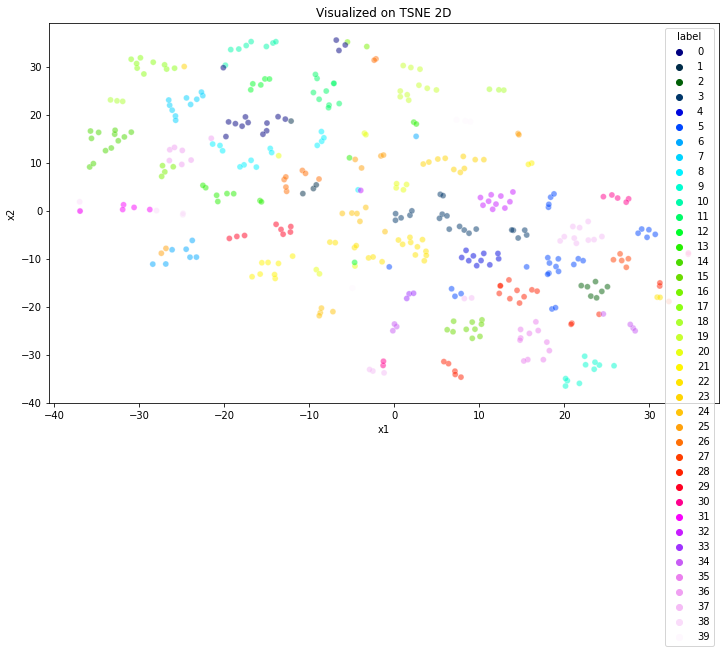

In [ ]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

#Visualisation des clusters grâce à un TSNE2D

tsne = TSNE(n_components=2).fit_transform(histogramme_circular)
PDtsne = pd.DataFrame(tsne)
PDtsne['label'] = lab
PDtsne.columns = ['x1','x2','label']
fig, ax = plt.subplots(1, figsize=(12,7))
sns.scatterplot(data=PDtsne,x='x1',y='x2',hue='label',legend="full",alpha=0.5,ax=ax, palette = "gist_ncar")
ax.set_title('Visualized on TSNE 2D')


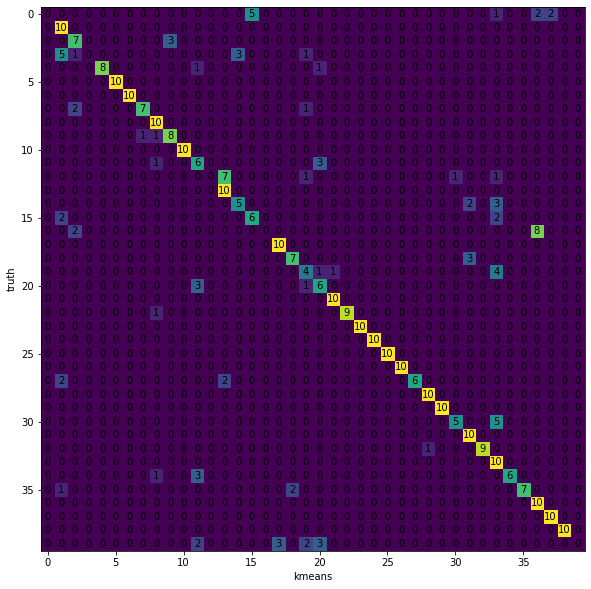

In [ ]:
from sklearn.metrics import confusion_matrix

k_lab_matched = np.empty_like(lab)

#Pour créer la confusion matrix, on match les pairs (vrai label, kmeans label) en maximisant le nombre
#de vrais positifs obtenus
#De cette facon, on peut faire correspondre les vrais labels et les labels du kmeans pour obtenir
#un résultat cohérent

for k in np.unique(lab):

    match_nums = [np.sum((lab==k)*(target==t)) for t in np.unique(target)]
    k_lab_matched[lab==k] = np.unique(target)[np.argmax(match_nums)]

cm = confusion_matrix(target, k_lab_matched)

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(cm,interpolation='none')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("kmeans")
plt.ylabel("truth")
plt.show()

## Tests de recherche d'information

In [ ]:
#Nous testons ici une fonction qui retourne les images les plus proches 
#d'une image passée en paramètre selon une distance spécifique

def test(img,histo_total, lbp_type):

    maxi = []

    if lbp_type == array_to_64:
        lbp = lbp_type(deepcopy(img),3)
        histogramm = hist_img(lbp,8)
        for i in range(400):
          maxi.append((chi(histogramm, histo_total[i]),i))
        maxi.sort(key = lambda x: x[0]) 

    else:
        lbp = lbp_type(deepcopy(img),8,2)
        histogramm = hist_img(lbp,8)
        for i in range(400):
          maxi.append((chi(histogramm, histo_total[i]),i))
        maxi.sort(key = lambda x: x[0]) 
        
    return maxi

In [ ]:
#Nous testons cette fonction avec l'image 0 et la distance chi en utilisant un LBP basique et circulaire

print(test(deepcopy(images[0,:,:]),histogramme_circular,circular_to_64))
print(test(deepcopy(images[0,:,:]),histogramme_basic,array_to_64))

[(0.0, 0), (3490.9720037974867, 2), (3987.988990219025, 6), (4032.9137308893446, 7), (4225.439066223699, 159), (4297.147050253391, 152), (4353.818437178955, 151), (4442.357532171106, 235), (4484.308925936434, 231), (4564.890228909345, 230), (4623.727034202763, 1), (4632.27332473288, 236), (4763.989344741411, 5), (4766.6992962078875, 234), (4795.063734570127, 158), (4808.418946007568, 233), (4816.754452973769, 115), (4857.020691489199, 238), (4889.151041390498, 239), (4904.439557585392, 110), (4905.2803914299375, 109), (4914.882471899823, 178), (4919.906393417144, 8), (4924.51572087552, 237), (4936.423359885964, 53), (4957.063654554983, 176), (4981.564319616229, 260), (4987.502717414462, 71), (4996.647383824498, 358), (5016.564489042634, 157), (5024.2279566021725, 54), (5038.012721920366, 55), (5038.058762803343, 266), (5038.900853791962, 179), (5058.676903714415, 56), (5064.166857408886, 124), (5067.988203277351, 136), (5075.256856113849, 87), (5078.438005009133, 84), (5079.49606611816

In [ ]:
#Cette fonction prépare l'utilisation de la classe Evaluator pour vérifier avec quelle précision 
#on arrive à obtenir les 9 autres images d'une personne à partir de 1 image par rapport à la fonction de test
#On définit ici le groundtruth

def groundtruth():

    liste_totale = []
    kbis=0
    k=0

    for i in range(400):

        liste_relevant = []

        for j in range(0,10):
                if j!=i-k:
                    liste_relevant.append(j+k)

        kbis+=1
        k=kbis
        k=int(m.floor(k / 10.0)) * 10
        dico = {'id':i,'relevant':liste_relevant}
        liste_totale.append(dico)

    ground = {'groundtruth' : liste_totale}
    
    return ground

In [ ]:
#On définit ici l'information retrieved qui correspond au résultat des plus proches images

def retrieved():

    liste_totale = []

    for i in range(400):

        res = test(deepcopy(images[i,:,:]),histogramme_circular,circular_to_64)
        liste_relevant = []

        for j in range(len(res)):
            score,idd = res[j]
            liste_relevant.append(idd)

        dico = {'id':i,'relevant':liste_relevant}
        liste_totale.append(dico)

    retrieved = {'retrieved' : liste_totale}
    
    return retrieved

### Evaluator : classe tirée du cours de M.TIRILLY

In [ ]:
#La classe Evaluator permet d'évaluer la mAP et la courbe ROC des queries (qui correspondent à 
#chaque image dans notre cas)

class Evaluator:
	''' Class for the evaluation of information retrieval systems.

	The class allows for the computation of:
	* the (recall, precision) points for a single query, after simple
	interpolation or 11-pt interpolation,
	* the average precision (AP) for a single query,
	* the averaged 11-pt interpolated (recall, precision) points for all
	queries,
	* the mean average precision (mAP) computed over all queries.

	Each Evaluator object should be build for the evaluation of a given run
	over a given dataset. Upon construction, one should provide:
	* the search results of the run over the dataset,
	* the groundtruth of the dataset.
	Search results and groundtruth should be provided as dictionaries with
	the following structure:
	{ 'groundtruth':
		[{'id':id_1, 'relevant':[rel_11, rel12, rel13...]},
		 {'id':id_2, 'relevant':[rel_21, rel22, rel23...]},
		 ...
		]
	}
	with id_i the id of a query and [rel_i1, rel_i2, rel_i3...] the list of
	relevant / retrieved documents for this query. This list must be sorted
	by estimated relevance for retrieved documents. The root element
	('groundtruth') may be different (e.g. 'run', 'retrieved'...) for the
	dictionary of search results.

	The evaluation measures and limit cases (absence of relevant documents
	or retrieved documents) are computed in the same way as in trec_eval.
	'''

	def __init__(self, retrieved, relevant):
		''' Constructor for an Evaluator object.

		Builds an Evaluator object for a run given the lists of
		relevant documents and retrieved documents for each query.
		These lists should follow the dictionary format described in
		the documentation of the class.

		:param retrieved: List of retrieved documents for each query,
		sorted by estimated relevance.
		:param relevant: List of relevant documents (groundtruth)
		for each query.
		:type retrieved: List of Dict
		:type relevant: List of Dict
		'''
		self._retrieved = self._flatten_json_qrel(retrieved, root=list(retrieved.keys())[0])
		self._relevant = self._flatten_json_qrel(relevant)


	def _flatten_json_qrel(self, json_qrel, root='groundtruth'):
		return {item['id']:item['relevant'] for item in json_qrel[root]}


	def _interpolate_11pts(self, rp_points):
		rp_11pts = []
		recalls = np.array([rp[0] for rp in rp_points])
		precisions = np.array([rp[1] for rp in rp_points])

		for recall_cutoff in np.arange(0., 1.01, .1):
			if np.count_nonzero(recalls >= recall_cutoff) > 0:
				rp_11pts.append((recall_cutoff, np.max(precisions[recalls >= recall_cutoff])))
			else:
				rp_11pts.append((recall_cutoff, 0.))
		return rp_11pts


	def _evaluate_query_pr(self, retrieved, relevant, interpolation_11pts=True):
		# if no grountruth is available
		if relevant is None or len(relevant) == 0:
			return None

		# if nothing was retrieved
		if retrieved is None or len(retrieved) == 0:
			if interpolation_11pts:
				return [(r, 0.) for r in np.arange(0., 1.01, .1)]
			else:
				return [(0.,0.)]

		# now we can work
		rp_points = {0.:(0.,0.)}
		tps = 0
		for i, retrieved_doc_id in enumerate(retrieved):
			if retrieved_doc_id in relevant:
				tps += 1
			recall = float(tps) / float(len(relevant))
			precision = float(tps) / float(i+1)
			if recall in rp_points:
				# keep best precision for given recall
				if precision > rp_points[recall][1]:
					rp_points[recall] = (recall, precision)
			else:
				rp_points[recall] = (recall, precision)

		rp_points = [rp_points[r] for r in sorted(rp_points.keys())]

		# fix P@0
		rp_points[0] = (0., rp_points[1][1])

		if interpolation_11pts:
			rp_points = self._interpolate_11pts(rp_points)

		return rp_points


	def _evaluate_query_ap(self, retrieved, relevant):
		# if no grountruth is available
		if relevant is None or len(relevant) == 0:
			return np.nan

		# if nothing was retrieved
		if retrieved is None or len(retrieved) == 0:
			return 0.

		# now we can work
		ap = 0.
		tps = 0
		for i, retrieved_doc_id in enumerate(retrieved):
			if retrieved_doc_id in relevant:
				tps += 1
				ap += float(tps) / float(i+1)

		return ap / len(relevant)


	''' Compute the interpolated (recall, precision) points for a given
	query.

	:param query_id: ID of the query to be evaluated.
	:param interpolation_11pts: if True, 11-pt interpolation is used.
	Otherwise, regular interpolation is used (Default: True).
	:type query_id: integer or string (depending on the data intially
	provided)
	:type interpolation_11pts: Bool

	:return: (recall, precision) points
	:rtype: list of (float, float) tuples
	'''
	def evaluate_query_pr_points(self, query_id, interpolation_11pts=True):
		return self._evaluate_query_pr(self._retrieved.get(query_id), self._relevant.get(query_id), interpolation_11pts)


	''' Compute the average precision (AP) for a given query.

	:param query_id: ID of the query to be evaluated.
	:type query_id: integer or string (depending on the data intially
	provided).

	:return: The AP for the query.
	:rtype: float
	'''
	def evaluate_query_ap(self, query_id, interpolation_11pts=True):
		return self._evaluate_query_ap(self._retrieved.get(query_id), self._relevant.get(query_id))


	''' Compute the 11-pt interpolated (recall, precision) points averaged
	over the queris of the run.

	:return: averaged (recall, precision) points
	:rtype: list of (float, float) tuples
	'''
	def evaluate_pr_points(self):
		precisions = []
		for i, qid in enumerate(self._relevant.keys()):
			q_pr = self._evaluate_query_pr(self._retrieved.get(qid), self._relevant[qid], interpolation_11pts=True)
			if q_pr is not None:
				precisions.append([pr[1] for pr in q_pr])
		return list(zip(np.arange(0., 1.01, .1), np.mean(np.array(precisions), axis=0)))


	''' Compute the mean average precision (mAP) over the set of queries of
	the run.

	:return: The mAP of the run.
	:rtype: float
	'''
	def evaluate_map(self):
		aps = np.array([self._evaluate_query_ap(self._retrieved.get(qid), self._relevant[qid]) for qid in self._relevant])
		return np.mean(aps[~np.isnan(aps)])


### Test de recherche d'information effectué sur Collab avec GPU (1h d'execution)

In [ ]:
"""evaluator = Evaluator(rtrv,grnd)
points = evaluator.evaluate_pr_points()#on calcule la courbe Rappel-Précision
mapp = evaluator.evaluate_map()#on calcule le mAP

x_val = [x[0] for x in points]#ce code permet de visualiser la courbe Rappel-Précision
y_val = [x[1] for x in points]

plt.plot(x_val,y_val)
plt.plot(x_val,y_val,'or')
plt.show()
print(mapp)"""

"evaluator = Evaluator(rtrv,grnd)\npoints = evaluator.evaluate_pr_points()#on calcule la courbe Rappel-Précision\nmapp = evaluator.evaluate_map()#on calcule le mAP\n\nx_val = [x[0] for x in points]#ce code permet de visualiser la courbe Rappel-Précision\ny_val = [x[1] for x in points]\n\nplt.plot(x_val,y_val)\nplt.plot(x_val,y_val,'or')\nplt.show()\nprint(mapp)"

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6638162a-6285-44fe-a7d2-11f6fd224863' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>